Simple gradient-based quadratic classification model to compute $W$. 

In [1]:
# ! pip install torch scikit-learn matplotlib -q

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import seaborn as sns
from scipy import stats
from sklearn.metrics import roc_auc_score


sys.path.append("..")

from src.models.quadratic import QuadraticModel, QuadMLP
from src.models.trainer import ModelTrainer
from src.config.config import cfg

np.set_printoptions(precision=2, suppress=True, linewidth=120)

In [3]:
hyp = {
    "data_paths": [
        "../data/encoded/S21_encoded_with_outcomes.csv",
        "../data/encoded/W21_encoded_with_outcomes.csv",
        "../data/encoded/S17_encoded_with_outcomes.csv",
        "../data/encoded/W17_encoded_with_outcomes.csv",
        "../data/encoded/top_companies_encoded_with_outcomes.csv"
    ],
    "synthetic_data_path": '../data/synth/encoded_founders_composites.csv',
    "test_size": 0.1,  
    "val_size": 0.2,  
    "random_state": 4,
    "batch_size": 64,
    "lr": 0.0001,
    "weight_decay": 1e-4,
    "epochs": 1000,
    "patience": 30,
    "lr_decay_factor": 0.3,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "exclude_columns": ["success", "exit_value", "funding_amount", "batch"],
    "target_column": "success"
}



In [4]:
# Load real data
real_data = pd.concat([
    pd.read_csv(path).assign(batch=path.split('/')[-1].split('_')[0]) 
    for path in hyp["data_paths"]
])

# Load synthetic data if path is provided
synthetic_data = None
if hyp["synthetic_data_path"]:
    synthetic_data = pd.read_csv(hyp["synthetic_data_path"])
    synthetic_data['batch'] = 'synthetic'  # Mark synthetic data

feature_columns = [col for col in real_data.columns if col not in hyp["exclude_columns"]]
feature_names = feature_columns

# First split real data to reserve test set
X_real = real_data[feature_columns].to_numpy()
y_real = real_data[hyp["target_column"]].values

X_real_train, X_test, y_real_train, y_test = train_test_split(
    X_real, y_real,
    test_size=hyp["test_size"],
    random_state=hyp["random_state"],
    shuffle=True,
    stratify=y_real  # Ensure balanced split
)

# Combine synthetic with real training data if available
if synthetic_data is not None:
    X_synth = synthetic_data[feature_columns].to_numpy()
    y_synth = synthetic_data[hyp["target_column"]].values
    
    X_train_combined = np.vstack([X_real_train, X_synth])
    y_train_combined = np.concatenate([y_real_train, y_synth])
    
    # Create mask to track synthetic vs real samples
    is_synthetic = np.concatenate([
        np.zeros(len(X_real_train)), 
        np.ones(len(X_synth))
    ])
else:
    X_train_combined = X_real_train
    y_train_combined = y_real_train
    is_synthetic = np.zeros(len(X_real_train))

# Split combined training data into train/val
X_train, X_val, y_train, y_val, is_synthetic_train, is_synthetic_val = train_test_split(
    X_train_combined, y_train_combined, is_synthetic,
    test_size=hyp["val_size"],
    random_state=hyp["random_state"],
    shuffle=True,
    stratify=y_train_combined  # Keep classes balanced
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train)
is_synthetic_train_tensor = torch.FloatTensor(is_synthetic_train)

X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val)
is_synthetic_val_tensor = torch.FloatTensor(is_synthetic_val)

X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test)

# Calculate class weights based on real data only
n_neg = (y_real_train == 0).sum()
n_pos = (y_real_train == 1).sum()
pos_weight = torch.tensor([n_neg / n_pos])

# Create dataset with synthetic flags
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, is_synthetic_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=hyp["batch_size"], shuffle=True)

# Initialize histories
train_loss_history, val_loss_history, test_loss_history = [], [], []
train_acc_history, val_acc_history, test_acc_history = [], [], []

# Print dataset statistics
print(f"\nDataset Statistics:")
print(f"Real Training samples: {len(X_real_train)}")
print(f"Synthetic samples: {len(X_synth) if synthetic_data is not None else 0}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"\nClass distribution in real training data:")
print(f"Positive: {(y_real_train == 1).sum()} ({(y_real_train == 1).mean():.2%})")
print(f"Negative: {(y_real_train == 0).sum()} ({(y_real_train == 0).mean():.2%})")

# Add distribution for synthetic data
if synthetic_data is not None:
    print(f"\nClass distribution in synthetic data:")
    print(f"Positive: {(y_synth == 1).sum()} ({(y_synth == 1).mean():.2%})")
    print(f"Negative: {(y_synth == 0).sum()} ({(y_synth == 0).mean():.2%})")
    
    # Show real/synthetic split across sets
    print(f"\nReal/Synthetic split:")
    print(f"Training set: {(is_synthetic_train == 0).sum()} real, {(is_synthetic_train == 1).sum()} synthetic")
    print(f"Validation set: {(is_synthetic_val == 0).sum()} real, {(is_synthetic_val == 1).sum()} synthetic")
    print(f"Test set: {len(X_test)} real, 0 synthetic (test set is real data only)")


Dataset Statistics:
Real Training samples: 1247
Synthetic samples: 2000
Validation samples: 650
Test samples: 139

Class distribution in real training data:
Positive: 454 (36.41%)
Negative: 793 (63.59%)

Class distribution in synthetic data:
Positive: 1107 (55.35%)
Negative: 893 (44.65%)

Real/Synthetic split:
Training set: 1009 real, 1588 synthetic
Validation set: 238 real, 412 synthetic
Test set: 139 real, 0 synthetic (test set is real data only)


In [5]:
input_dim = X_train.shape[1]
model = QuadMLP(input_dim)
model = model.to(hyp['device'])
W_init = model.W.clone().detach().to(hyp['device'])

trainer = ModelTrainer(model, hyp, pos_weight)
trainer.train(train_loader, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor)

# Save with proper path handling
from pathlib import Path
model_dir = Path("../models")
model_dir.mkdir(exist_ok=True)
torch.save(model.state_dict(), model_dir / "founder_rank.pt")

# Evaluation with explicit device handling
model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(hyp["device"])
    logits = model(X_test_device)
    probs = torch.sigmoid(logits).cpu().numpy()
    test_preds = (probs > 0.5).astype(int)

W_final = model.get_W().detach().cpu().numpy()
b_final = model.b.item()

# Create evaluation DataFrame
sample_df = pd.DataFrame(X_test[:10], columns=feature_names)
sample_df['raw_logit'] = logits.cpu().numpy()[:10]
sample_df['probability'] = probs[:10].round(3)
sample_df['predicted'] = test_preds[:10]
sample_df['true_label'] = y_test[:10]

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
print(sample_df)

/Users/Viresh/Desktop/Spring 2025/Angel Network/founder-rank/venv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0:
Train Loss = 46.9709, Val Loss = 46.9445
Val Pearson = 0.0000
Val Spearman = 0.0000
Val AUC-ROC = 0.5000
---
Epoch 5:
Train Loss = 46.1473, Val Loss = 46.1095
Val Pearson = 0.0000
Val Spearman = 0.0000
Val AUC-ROC = 0.5000
---
Epoch 10:
Train Loss = 45.4276, Val Loss = 45.3944
Val Pearson = 0.0000
Val Spearman = 0.0000
Val AUC-ROC = 0.5000
---
Epoch 15:
Train Loss = 44.7817, Val Loss = 44.7598
Val Pearson = 0.0000
Val Spearman = 0.0000
Val AUC-ROC = 0.5000
---
Epoch 20:
Train Loss = 44.1749, Val Loss = 44.1762
Val Pearson = 0.0000
Val Spearman = 0.0000
Val AUC-ROC = 0.5000
---
Epoch 25:
Train Loss = 43.6136, Val Loss = 43.6201
Val Pearson = 0.0000
Val Spearman = 0.0000
Val AUC-ROC = 0.5000
---
Epoch 30:
Train Loss = 43.0433, Val Loss = 43.0813
Val Pearson = 0.0000
Val Spearman = 0.0000
Val AUC-ROC = 0.5000
---
Epoch 35:
Train Loss = 42.5128, Val Loss = 42.5532
Val Pearson = 0.0000
Val Spearman = 0.0000
Val AUC-ROC = 0.5000
---
Epoch 40:
Train Loss = 41.9715, Val Loss = 42.0307

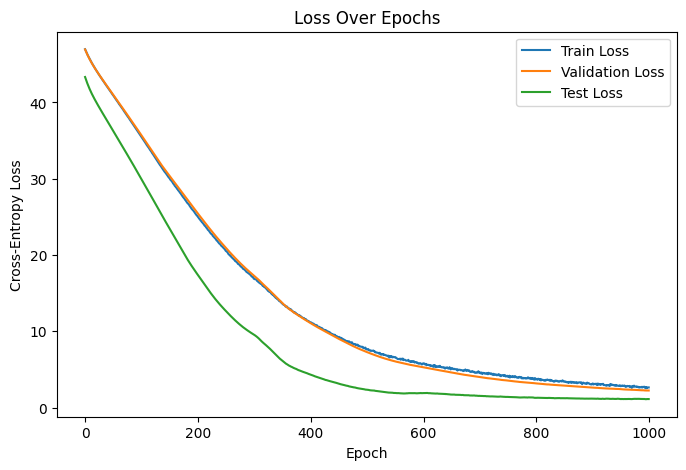

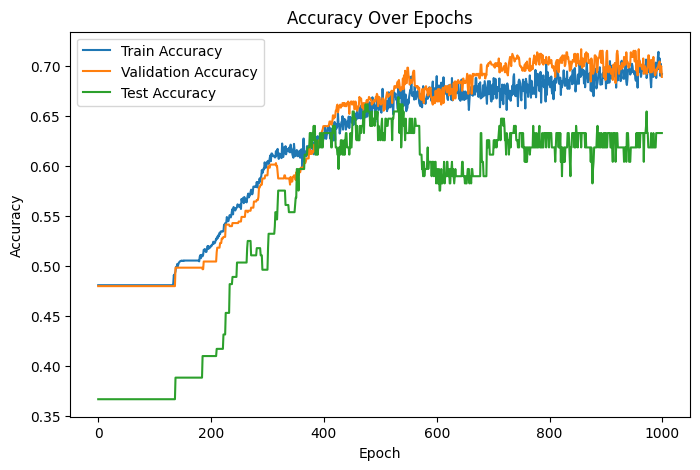

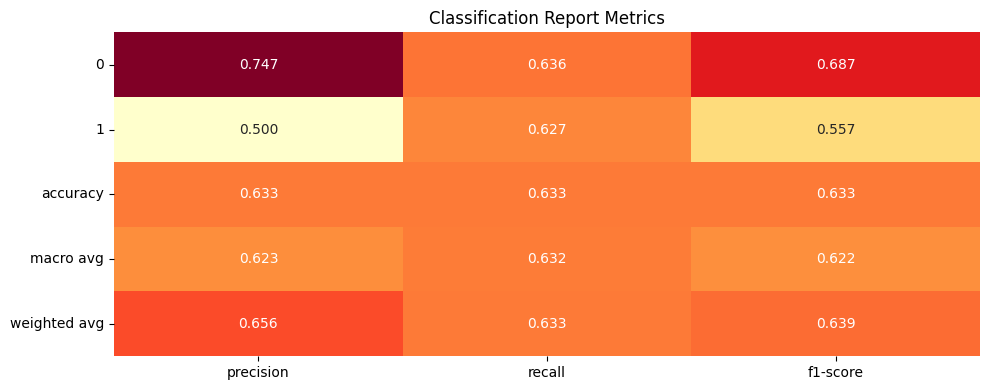

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(trainer.train_loss_history, label="Train Loss")
plt.plot(trainer.val_loss_history, label="Validation Loss")
plt.plot(trainer.test_loss_history, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.show()

# Accuracy curves
plt.figure(figsize=(8, 5))
plt.plot(trainer.train_acc_history, label="Train Accuracy")
plt.plot(trainer.val_acc_history, label="Validation Accuracy")
plt.plot(trainer.test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()

report = classification_report(y_test, test_preds, output_dict=True)
report_df = pd.DataFrame(report).round(3).T
report_df = report_df.drop("support", axis=1)

plt.figure(figsize=(10, 4))
sns.heatmap(report_df, annot=True, cmap="YlOrRd", fmt=".3f", cbar=False)
plt.title("Classification Report Metrics")
plt.tight_layout()
plt.show()

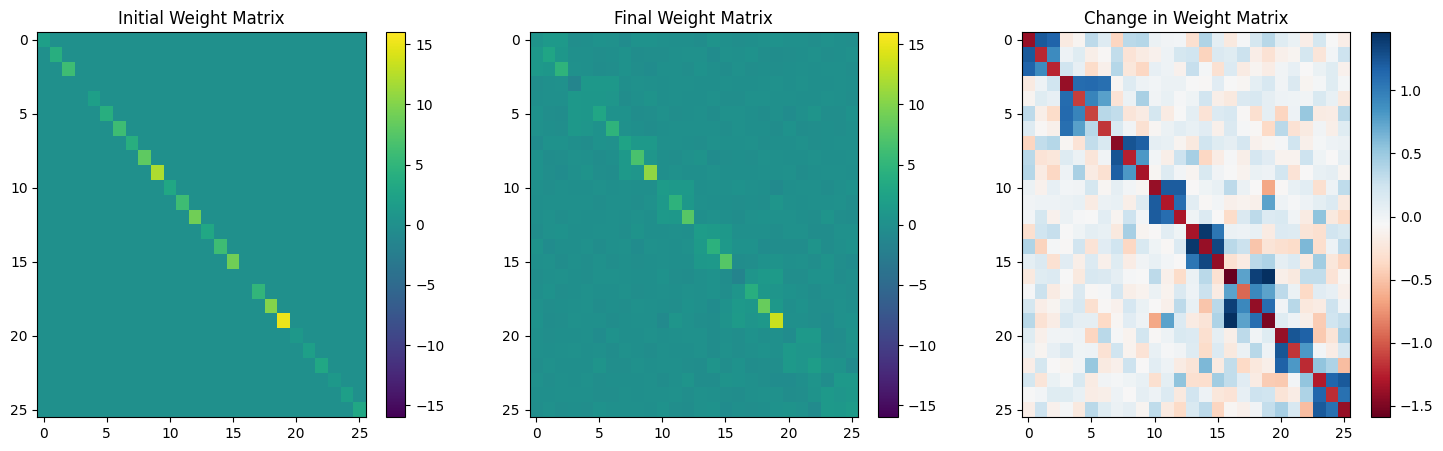

In [7]:
vmin, vmax = -16, 16

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
im0 = axs[0].imshow(W_init.cpu().numpy(), aspect="auto", cmap="viridis", vmin=vmin, vmax=vmax)
axs[0].set_title("Initial Weight Matrix")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(W_final, aspect="auto", cmap="viridis", vmin=vmin, vmax=vmax)
axs[1].set_title("Final Weight Matrix")
plt.colorbar(im1, ax=axs[1])

W_diff = W_final - W_init.cpu().numpy()
im2 = axs[2].imshow(W_diff, aspect="auto", cmap="RdBu")
axs[2].set_title("Change in Weight Matrix")
plt.colorbar(im2, ax=axs[2])
plt.show()

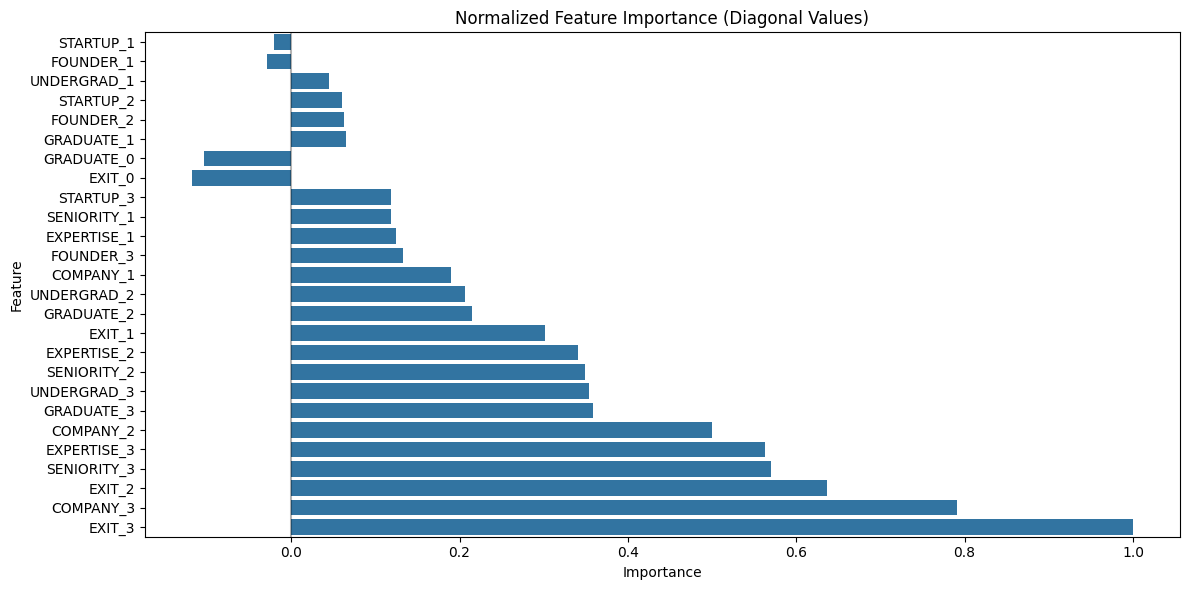

In [8]:
# Plot Feature Importance
feature_importance = np.abs(np.diag(W_final))
feature_pairs = np.abs(W_final - np.diag(np.diag(W_final)))
feature_names = real_data[feature_columns].columns  # Changed from real_data to data

feature_importance_abs = np.abs(np.diag(W_final))
feature_importance_real = np.diag(W_final)
feature_importance_normalized = feature_importance_real / np.max(np.abs(feature_importance_real))

importance_df = pd.DataFrame(
    {
        "Feature": feature_names,
        "Importance": feature_importance_normalized,
        "Importance_abs": np.abs(feature_importance_normalized),
    }
).sort_values("Importance_abs", ascending=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df, y="Feature", x="Importance")
plt.title("Normalized Feature Importance (Diagonal Values)")
plt.axvline(x=0, color="black", linestyle="-", alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/0h/b0b6qlp97wxd6bw8pzg5jm280000gq/T/ipykernel_93613/1467078364.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


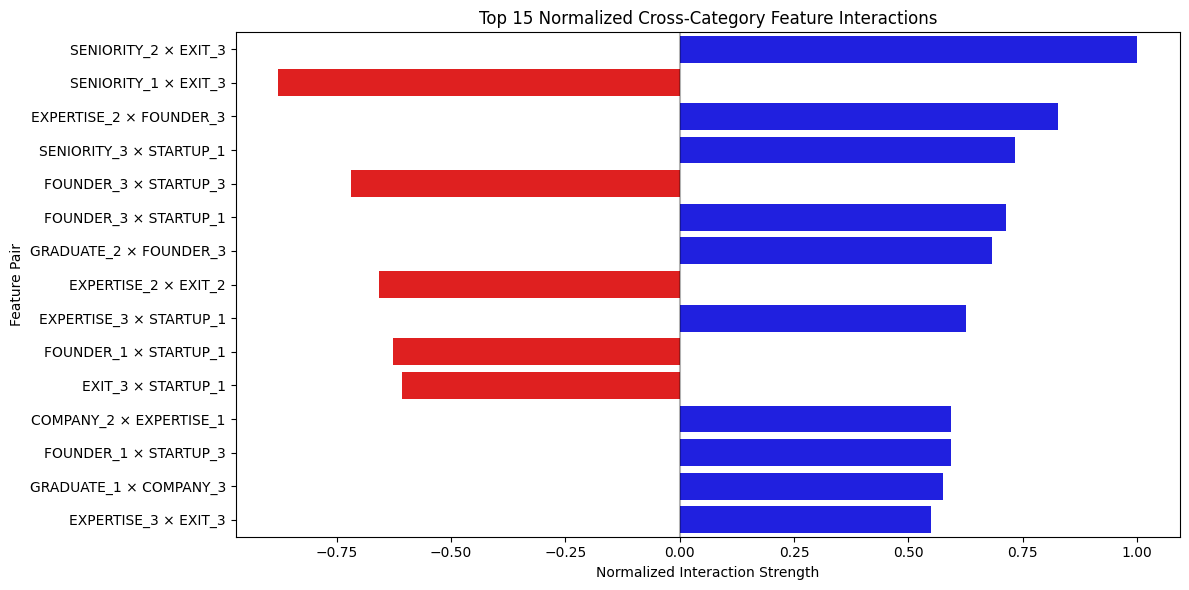

In [9]:
MATRIX = cfg.MATRIX
category_map = {}
start_idx = 0
for cat in MATRIX:
    dim = MATRIX[cat]["DIMENSION"]
    end_idx = start_idx + dim
    for i in range(start_idx, end_idx):
        category_map[feature_names[i]] = cat
    start_idx = end_idx

upper_triangle = np.triu(W_final, k=1)

pairs = []
for i in range(len(upper_triangle)):
    for j in range(i + 1, len(upper_triangle)):
        cat1 = category_map[feature_names[i]]
        cat2 = category_map[feature_names[j]]
        if cat1 != cat2:  # Only include pairs from different categories
            pairs.append((feature_names[i], feature_names[j], upper_triangle[i, j]))


interactions_df = pd.DataFrame(pairs, columns=["Feature 1", "Feature 2", "Interaction Strength"])
max_abs_interaction = np.max(np.abs(interactions_df["Interaction Strength"]))
interactions_df["Interaction Strength"] = interactions_df["Interaction Strength"] / max_abs_interaction
interactions_df["Abs_Strength"] = np.abs(interactions_df["Interaction Strength"])
interactions_df = interactions_df.sort_values("Abs_Strength", ascending=False)

plt.figure(figsize=(12, 6))
top_n = 15
top_interactions = interactions_df.head(top_n)

colors = ["red" if x < 0 else "blue" for x in top_interactions["Interaction Strength"]]
sns.barplot(
    data=top_interactions,
    y=top_interactions.apply(lambda x: f"{x['Feature 1']} × {x['Feature 2']}", axis=1),
    x="Interaction Strength",
    palette=colors,
)

plt.title(f"Top {top_n} Normalized Cross-Category Feature Interactions")
plt.xlabel("Normalized Interaction Strength")
plt.ylabel("Feature Pair")
plt.axvline(x=0, color="black", linestyle="-", alpha=0.3)
plt.tight_layout()
plt.show()

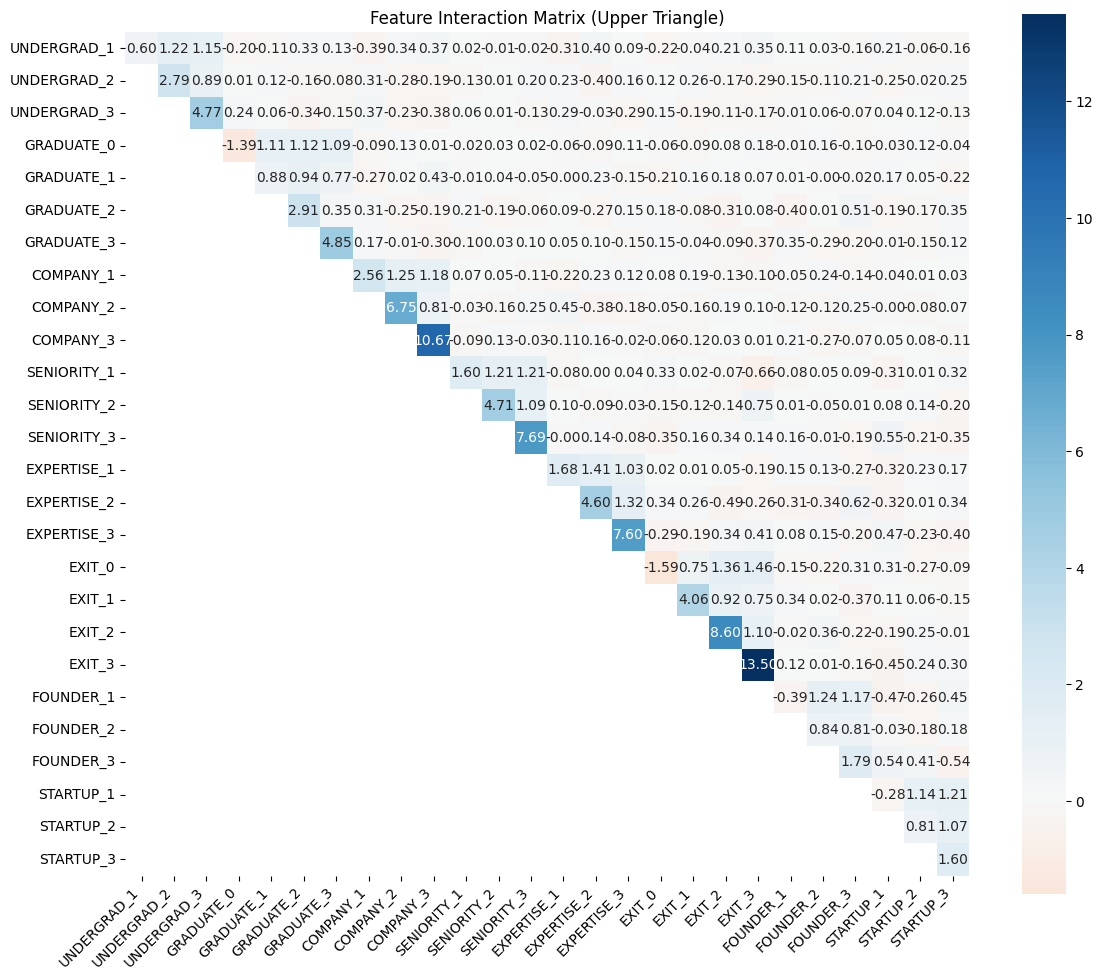

In [10]:
plt.figure(figsize=(12, 10))
mask = np.zeros_like(W_final)
mask[np.tril_indices_from(mask, k=-1)] = True

sns.heatmap(
    W_final,
    xticklabels=feature_names,
    yticklabels=feature_names,
    cmap="RdBu",
    center=0,
    mask=mask,
    annot=True,
    fmt=".2f",
    square=True,
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Feature Interaction Matrix (Upper Triangle)")
plt.tight_layout()
plt.show()

/var/folders/0h/b0b6qlp97wxd6bw8pzg5jm280000gq/T/ipykernel_93613/2767252859.py:22: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=analysis_df[~analysis_df["correct"]], x=feature, label="Incorrect", alpha=0.6)
/var/folders/0h/b0b6qlp97wxd6bw8pzg5jm280000gq/T/ipykernel_93613/2767252859.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=analysis_df[analysis_df["correct"]], x=feature, label="Correct", alpha=0.6)
/var/folders/0h/b0b6qlp97wxd6bw8pzg5jm280000gq/T/ipykernel_93613/2767252859.py:22: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=analysis_df[~analysis_df["correct"]], x=feature, label="Incorrect", alpha=0.6)
/var/folders/0h/b0b6qlp97wxd6bw8pzg5jm280000gq/T/ipykernel_93613/2767252859.py:21: UserWarning: Dataset has 0 va

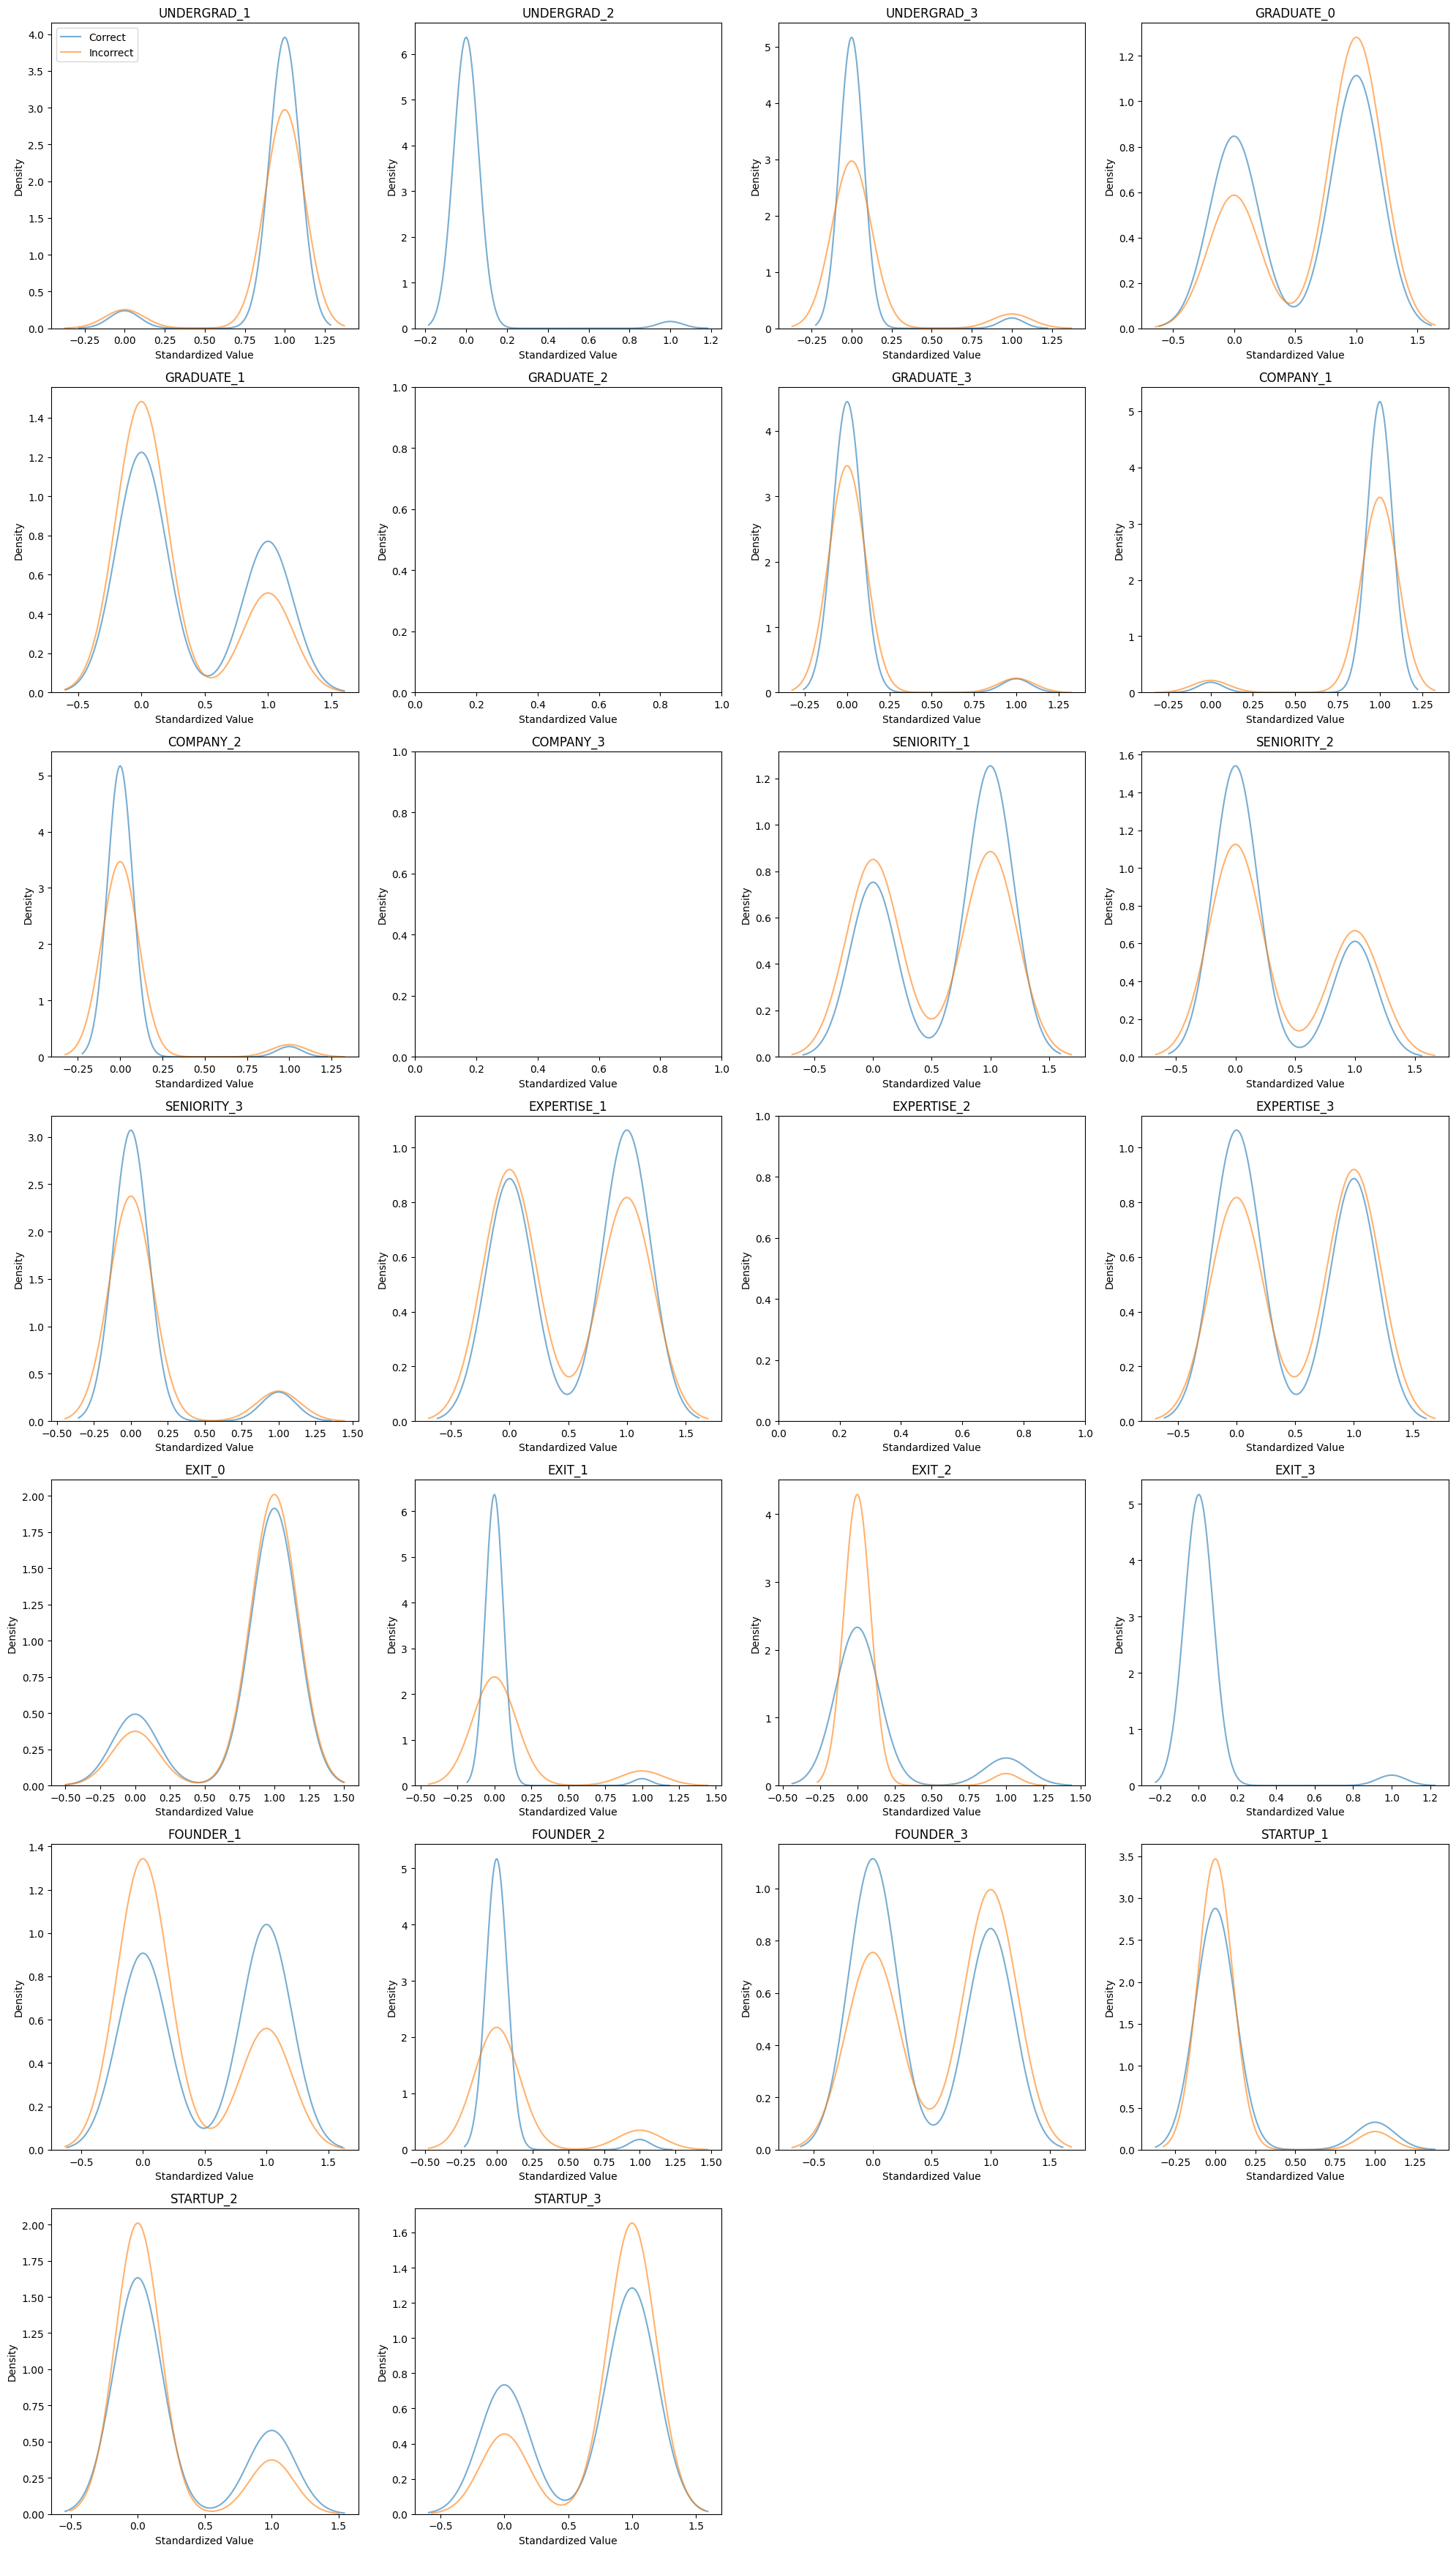


Feature Means for High Confidence Predictions:
             High Conf Correct  High Conf Incorrect  All Data
UNDERGRAD_1              0.926                0.667     0.935
UNDERGRAD_2              0.000                0.000     0.014
UNDERGRAD_3              0.074                0.333     0.050
GRADUATE_0               0.519                0.333     0.612
GRADUATE_1               0.407                0.333     0.338
GRADUATE_2               0.000                0.000     0.000
GRADUATE_3               0.074                0.333     0.050
COMPANY_1                0.926                0.889     0.957
COMPANY_2                0.074                0.111     0.043
COMPANY_3                0.000                0.000     0.000
SENIORITY_1              0.667                0.333     0.583
SENIORITY_2              0.185                0.333     0.317
SENIORITY_3              0.148                0.333     0.101
EXPERTISE_1              0.407                0.556     0.518
EXPERTISE_2           

In [11]:
# Get model predictions and confidence
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(hyp["device"])
    logits = model(X_test_tensor)
    probs = torch.sigmoid(logits).cpu().numpy()
    preds = (probs > 0.5).astype(int)

analysis_df = pd.DataFrame(X_test, columns=feature_names)
analysis_df["true_label"] = y_test
analysis_df["predicted"] = preds
analysis_df["confidence"] = np.abs(probs - 0.5) + 0.5
analysis_df["correct"] = analysis_df["true_label"] == analysis_df["predicted"]

n_features = len(feature_names)
n_rows = (n_features + 3) // 4

plt.figure(figsize=(20, 5 * n_rows))

for i, feature in enumerate(feature_names):
    plt.subplot(n_rows, 4, i + 1)
    sns.kdeplot(data=analysis_df[analysis_df["correct"]], x=feature, label="Correct", alpha=0.6)
    sns.kdeplot(data=analysis_df[~analysis_df["correct"]], x=feature, label="Incorrect", alpha=0.6)
    plt.title(f"{feature}")
    plt.xlabel("Standardized Value")
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

# Calculate and show means for all features
confidence_threshold = np.percentile(analysis_df["confidence"], 75)
high_conf_correct = analysis_df[(analysis_df["correct"]) & (analysis_df["confidence"] >= confidence_threshold)]
high_conf_incorrect = analysis_df[(~analysis_df["correct"]) & (analysis_df["confidence"] >= confidence_threshold)]

comparison_df = pd.DataFrame(
    {
        "High Conf Correct": high_conf_correct[feature_names].mean(),
        "High Conf Incorrect": high_conf_incorrect[feature_names].mean(),
        "All Data": analysis_df[feature_names].mean(),
    }
).round(3)

print("\nFeature Means for High Confidence Predictions:")
print(comparison_df)